In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from source import run_algorithm_analysis, return_class

pd.options.display.max_rows = 999
plt.style.use('fivethirtyeight')

# Task: predict popularity of the song on `Spotify` based on audio features

This is a notebook for the [blog post](http://blog.vaidasarmonas.tech/http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-1.html). The main idea is to investigate Machine Learning Design Patterns described in [this](https://www.oreilly.com/library/view/machine-learning-design/9781098115777/) book. This ispecific notebook is investigation of two design patterns - **Reframing** and **Neutral Class**. 

Data was downloaded from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and you can find a description of this dataset there.

## Load data and quick EDA

In [2]:
data = pd.read_csv("./spotify_track_features_data.csv")

In [3]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
print(f"Number of records in the dataset: {len(data)}")

Number of records in the dataset: 170653


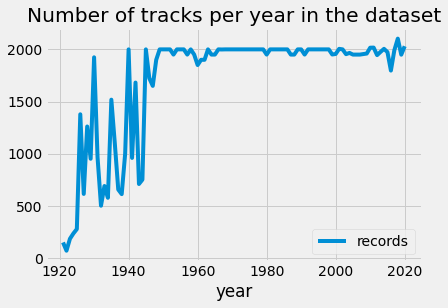

In [5]:
_ = data[["year", "key"]].groupby("year").count().reset_index().rename(columns={"key": "records"}).plot(x="year", y="records")
_ = plt.title("Number of tracks per year in the dataset")


It seems that it's a random sample (~2k) of songs released in specific year.

Let's keep only songs from the last decade (2011-2020) and see feature distribution

In [6]:
data_last_decade = data[data["year"] >= 2011]
print(f"Total tracks from the last decadelen: {len(data_last_decade)}")

Total tracks from the last decadelen: 19788


Split our dataset to train/test data before moving forward

In [7]:
AUDIO_FEATURES = [
    "valence",
    "acousticness",
    "danceability",
    "energy",
    "explicit",
    "instrumentalness",
    "key",
    "liveness",
    "mode",
    "speechiness",
    "tempo",
]
TARGET = "popularity"

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_last_decade[AUDIO_FEATURES], data_last_decade[TARGET], test_size=0.2, random_state=42)

In [9]:
# Preparing alternative targets for classification
y_train_class_median = (y_train > y_train.median()).astype(float)

y_train_class_middle_removed = y_train[(y_train <= y_train.quantile(.4)) | (y_train >= y_train.quantile(.6))]
y_train_class_middle_removed_bin = (y_train_class_middle_removed > 60.0).astype(float)
X_train_middle_removed = X_train.loc[y_train_class_middle_removed.index]

y_train_class_neutral = y_train.apply(lambda v: return_class(v, y_train.quantile(.4), y_train.quantile(.6)))

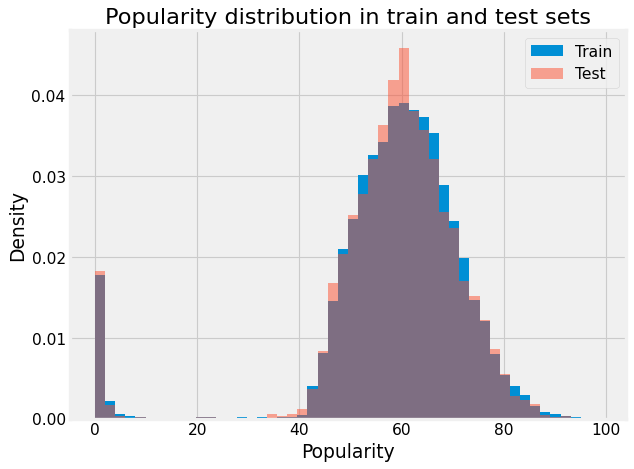

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_, bins, _ = plt.hist(y_train.to_list(), bins=50, density=True, label="Train")
_ = plt.hist(y_test.to_list(), bins=bins, alpha=0.5, density=True, label="Test")
_ = plt.title("Popularity distribution in train and test sets")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [11]:
y_train.describe()

count    15830.000000
mean        58.889071
std         15.300208
min          0.000000
25%         54.000000
50%         61.000000
75%         67.000000
max         99.000000
Name: popularity, dtype: float64

In [12]:
y_test.describe()

count    3958.000000
mean       58.576554
std        15.135913
min         0.000000
25%        53.000000
50%        60.000000
75%        67.000000
max       100.000000
Name: popularity, dtype: float64

# Feature distribution by year

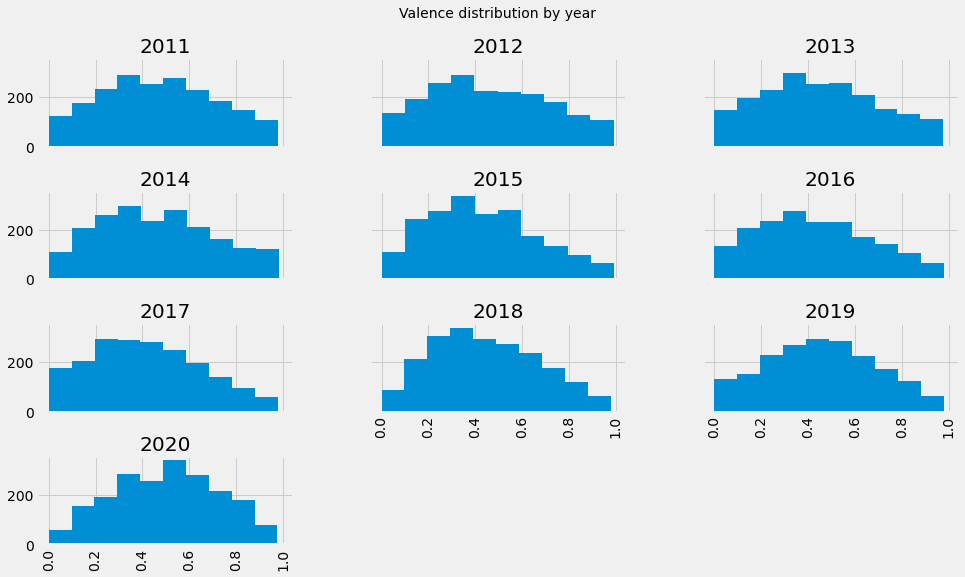

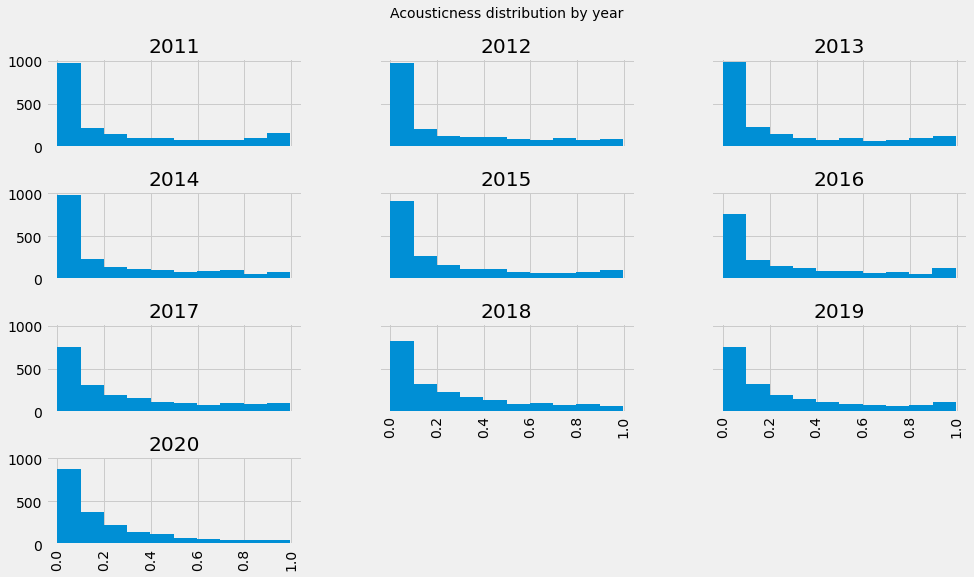

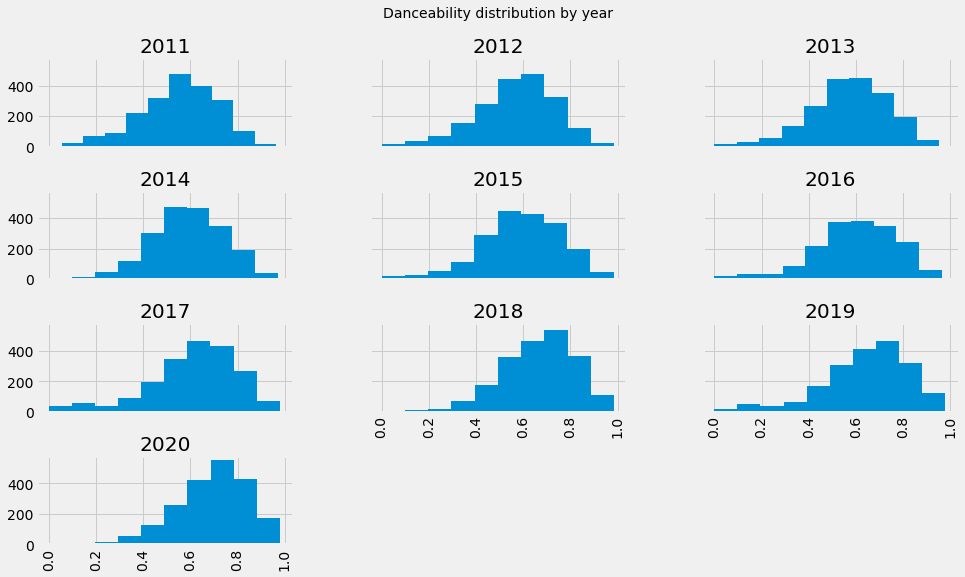

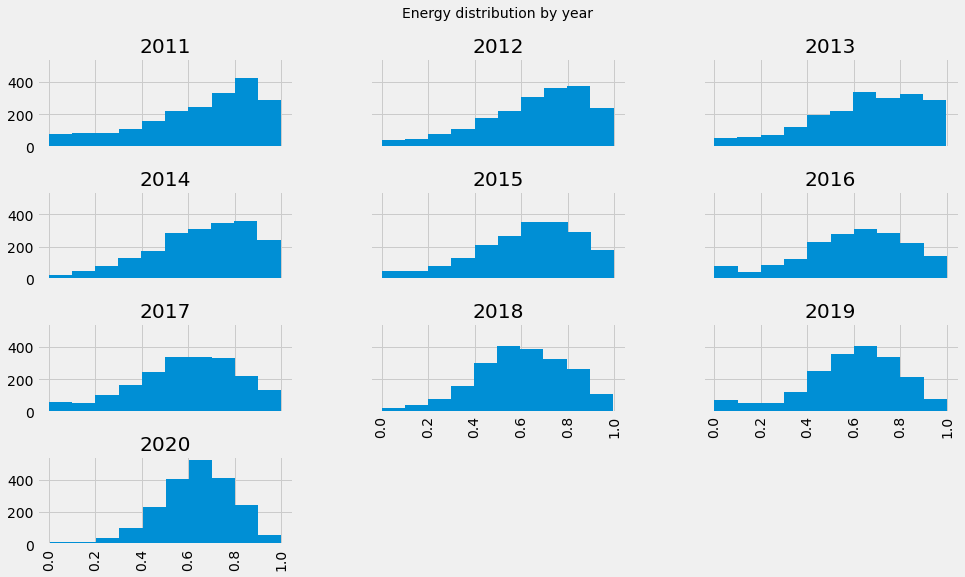

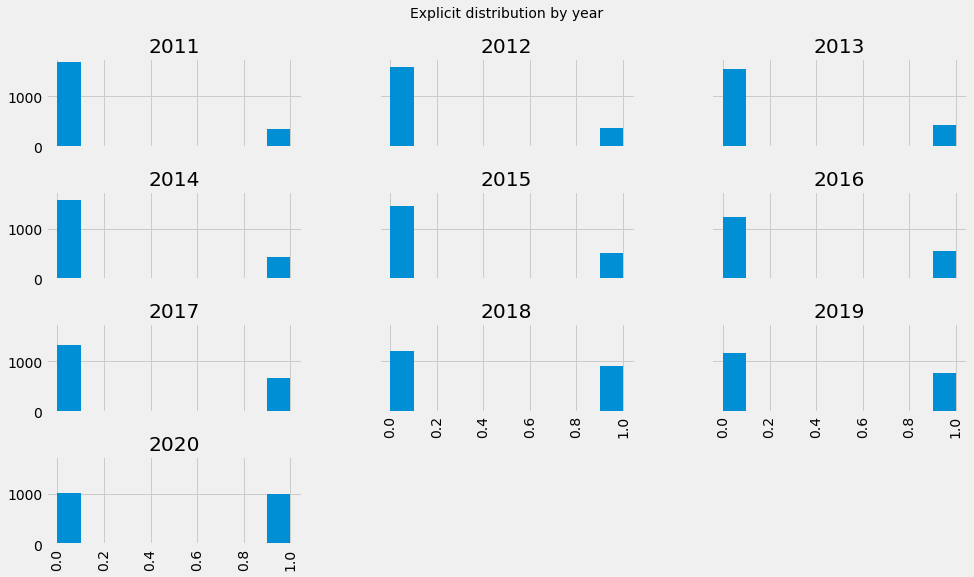

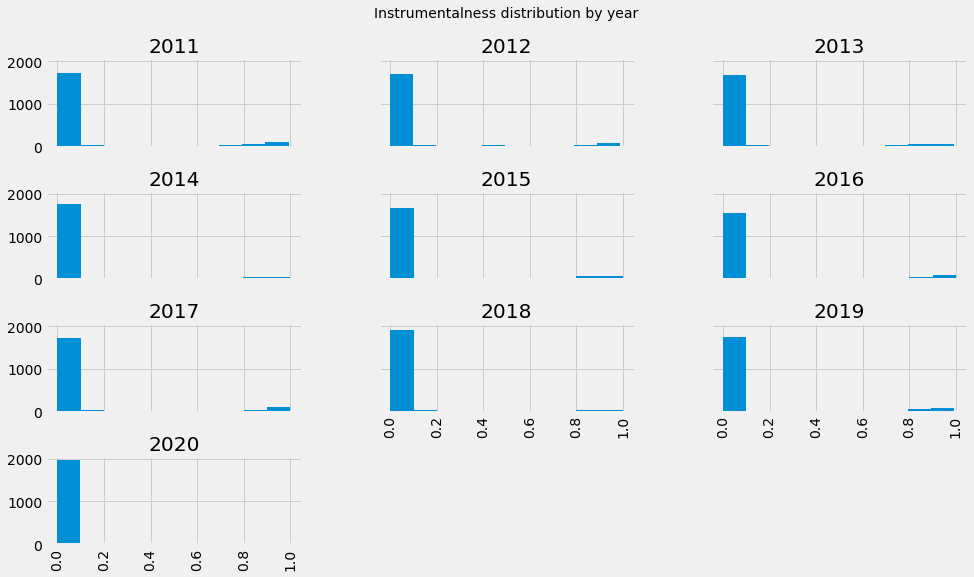

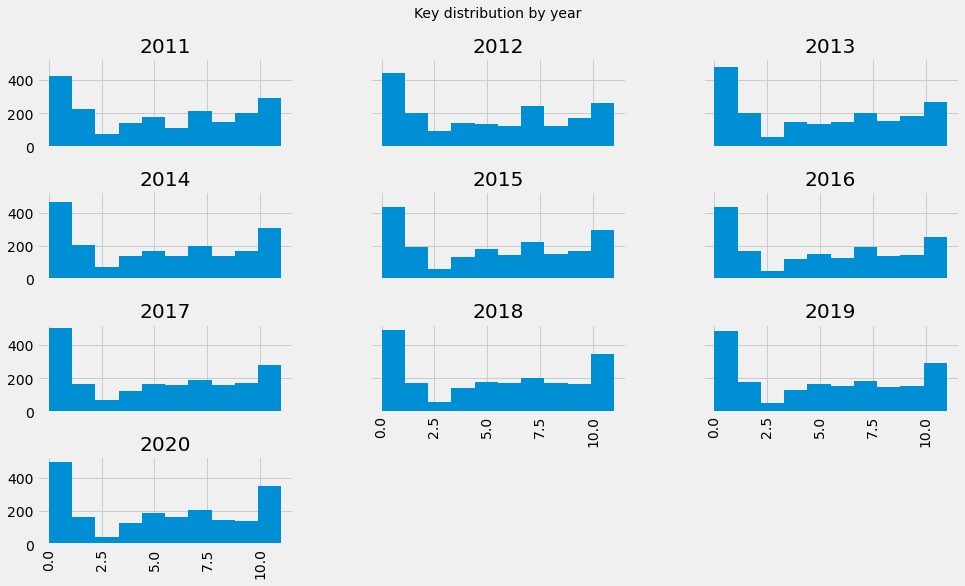

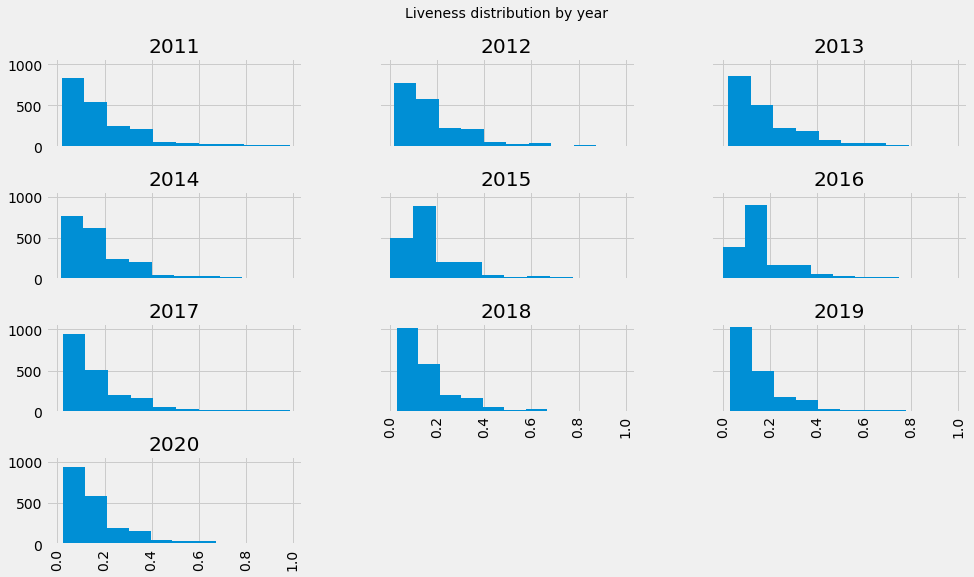

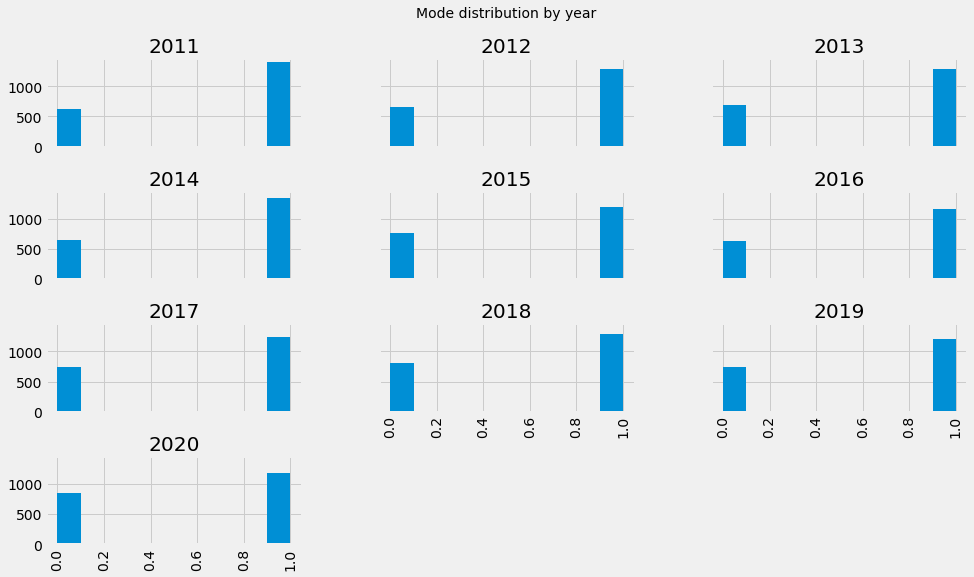

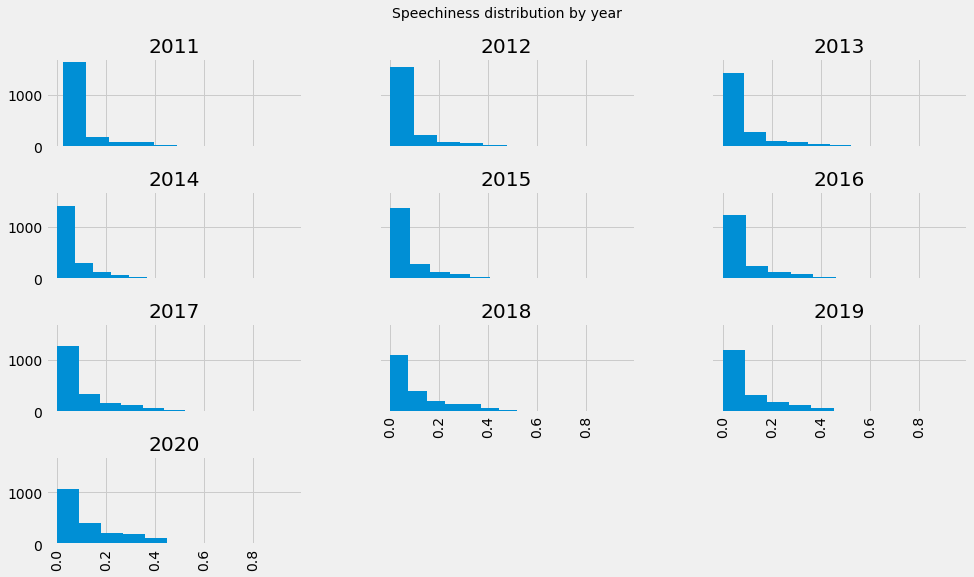

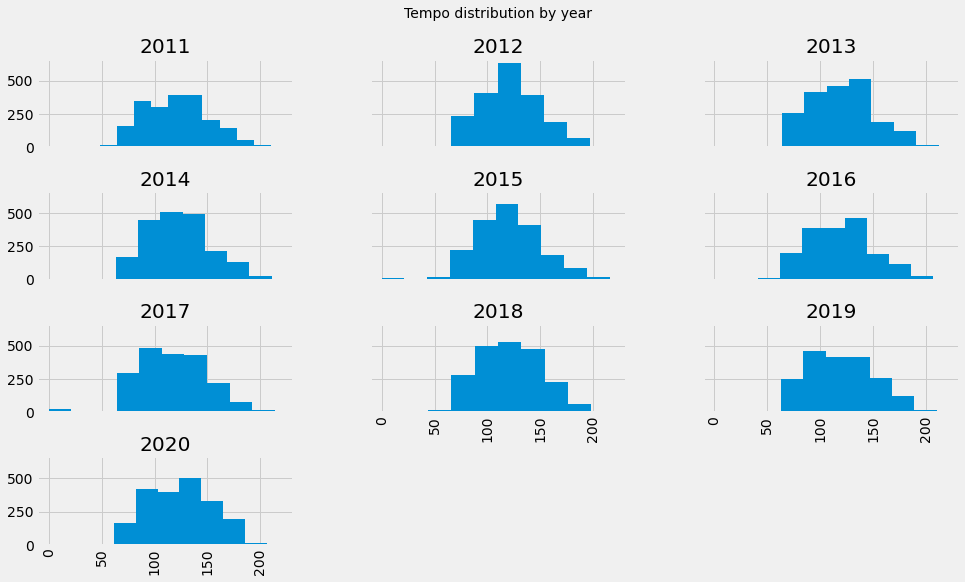

In [13]:
for feature in AUDIO_FEATURES:
    _ = data_last_decade[feature].hist(by=data_last_decade.year, sharey=True, sharex=True, figsize=(16,9))
    plt.suptitle(f"{feature.title()} distribution by year", fontsize=14)

Looking at feature distribution by year, we clearly see shifts in Audio features, which just ilustrates that music change over time.


## Popularity distribution by year

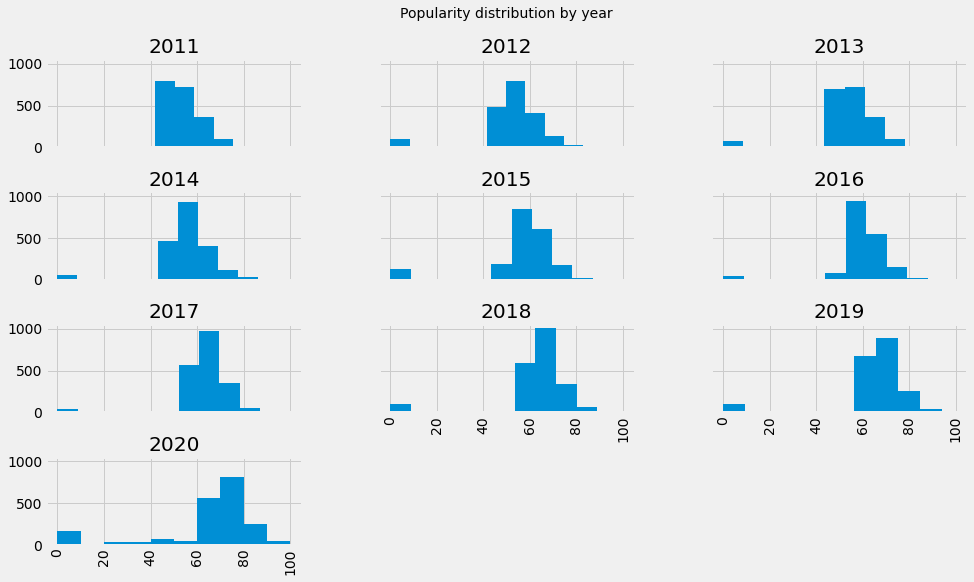

In [14]:
_ = data_last_decade[TARGET].hist(by=data_last_decade.year, sharey=True, sharex=True, figsize=(16,9))
_ = plt.suptitle(f"{TARGET.title()} distribution by year", fontsize=14)

Looking at the distribution of popularity we also see that more recent tracks are more popular now - no surprice. Putting together feature and popularity distribution I think we should be able to predict popular songs quite well.

# Modeling

In [15]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

## Regression on Popularity Score

<span style='color:None'>**Correlations between predicted and actual values for the Test Set**</span>

| Metric | Value | p-value |
    | ------ | ----- | ------- |
    | Spearman's Rho | 0.270 | 5.52E-67 |
    | Kendall's Tau | 0.184 | 6.47E-66 |

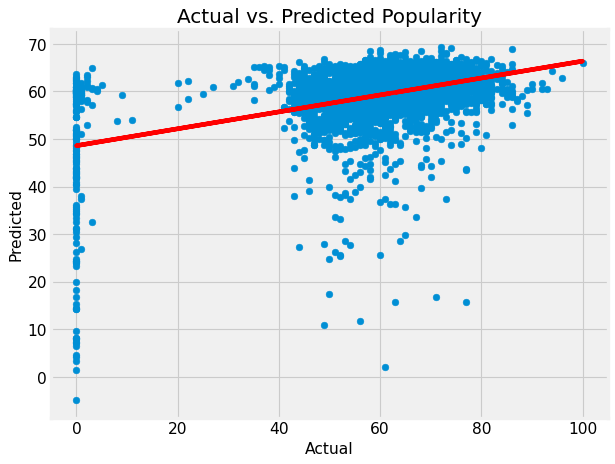

In [16]:
_, _ = run_algorithm_analysis("Regression on Popularity Score", GradientBoostingRegressor, X_train, y_train, X_test, y_test)

## Classification with Median Threshold

<span style='color:None'>**Correlations between predicted and actual values for the Test Set**</span>

| Metric | Value | p-value |
    | ------ | ----- | ------- |
    | Spearman's Rho | 0.307 | 5.62E-87 |
    | Kendall's Tau | 0.210 | 2.68E-85 |

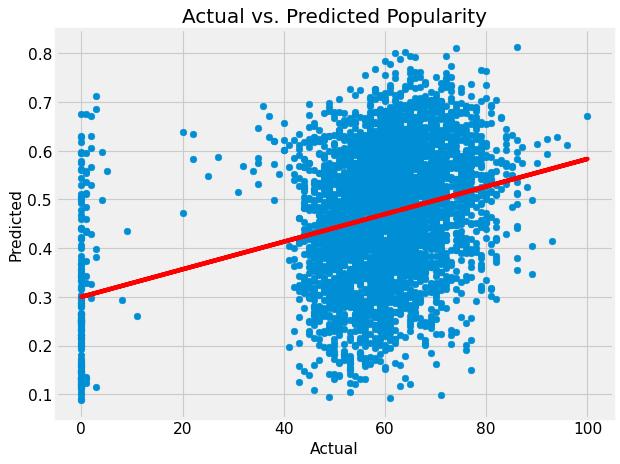

In [17]:
_, _ = run_algorithm_analysis("Classification with Median Threshold", GradientBoostingClassifier, X_train, y_train_class_median, X_test, y_test)


## Classification with Middle Values Removed

<span style='color:None'>**Correlations between predicted and actual values for the Test Set**</span>

| Metric | Value | p-value |
    | ------ | ----- | ------- |
    | Spearman's Rho | 0.303 | 7.06E-85 |
    | Kendall's Tau | 0.207 | 1.22E-82 |

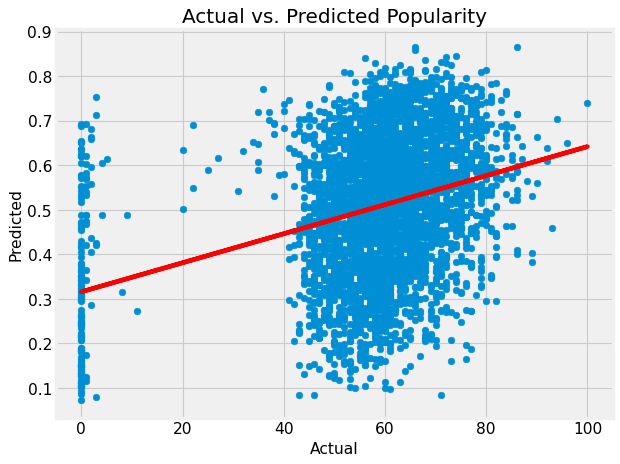

In [18]:
_, _ = run_algorithm_analysis("Classification with Middle Values Removed", GradientBoostingClassifier, X_train_middle_removed, y_train_class_middle_removed_bin, X_test, y_test)


## Classification with Neutral Class

<span style='color:None'>**Correlations between predicted and actual values for the Test Set**</span>

| Metric | Value | p-value |
    | ------ | ----- | ------- |
    | Spearman's Rho | 0.308 | 7.61E-88 |
    | Kendall's Tau | 0.211 | 6.66E-86 |

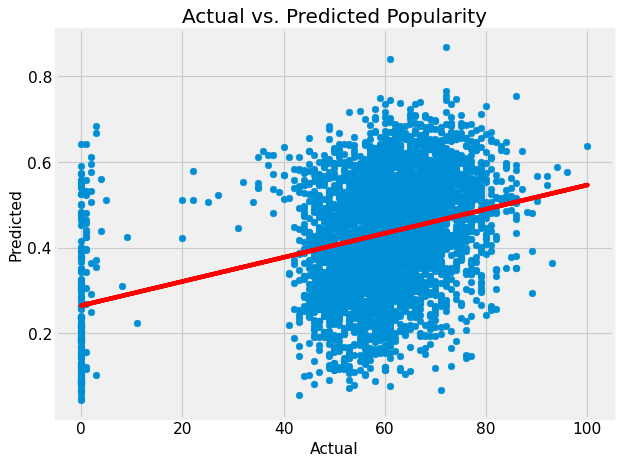

In [19]:
_, _ = run_algorithm_analysis("Classification with Neutral Class", GradientBoostingClassifier, X_train, y_train_class_neutral, X_test, y_test)
